## Loading the data

In [1]:
# import necessary libraries
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
from tensorflow.keras.optimizers import Nadam
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [2]:
# Set up API key and parametrs
api_key = "YOUR-API-KEY" 
symbol = "WTI"
function = "TIME_SERIES_DAILY"
outputsize = "full"

In [3]:
# Construct the API URL
url = f"https://www.alphavantage.co/query?function={function}&symbol={symbol}&outputsize={outputsize}&apikey={api_key}"

# Fetch the data from Alpha Vantage
response = requests.get(url)
data_json = response.json()

# Identify the key that contains the time-series data (e.g., "Time Series (Daily)")
time_series_key = None
for key in data_json.keys():
    if "Time Series" in key:
        time_series_key = key
        break

if time_series_key is None:
    raise ValueError("Time series data key not found in the response. Check your API call and parameters.")

### Data Pre-processing

In [5]:
# Convert the JSON time series to a DataFrame
data = data_json[time_series_key]
df = pd.DataFrame.from_dict(data, orient="index")

# Convert the index to datetime and sort in ascending order
df.index = pd.to_datetime(df.index)
df.sort_index(inplace=True)

# Extract and convert the closing price to float
df["4. close"] = df["4. close"].astype(float)
price_data = df[["4. close"]].rename(columns={"4. close": "Close"})

# Normalize the closing price between 0 and 1 (done for the RNN efficiency)
scaler = MinMaxScaler(feature_range=(0, 1))
price_data["Normalized"] = scaler.fit_transform(price_data[["Close"]])

### Setting up Features

In [7]:
# Create a dataset using a sliding window (lagged features)
def create_dataset(data, look_back=4):
    X, Y = [], []
    for i in range(look_back, len(data)):
        X.append(data[i-look_back:i])
        Y.append(data[i])
    return np.array(X), np.array(Y)

look_back = 4  # Using 4 lag days as in the paper for best performance
X, Y = create_dataset(price_data["Normalized"].values, look_back)

# Reshape the input to be [samples, timesteps, features]
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

### Splitting the Data

In [9]:
# Split the dataset into training (72%), validation (8%), and testing (20%)
total_samples = len(X)
train_size = int(total_samples * 0.72)
val_size = int(total_samples * 0.08)

X_train = X[:train_size]
Y_train = Y[:train_size]
X_val = X[train_size:train_size+val_size]
Y_val = Y[train_size:train_size+val_size]
X_test = X[train_size+val_size:]
Y_test = Y[train_size+val_size:]

### Set up the GRU Model 

In [11]:
model = Sequential()
# Add a GRU layer (50 units here is an example; adjust as needed)
model.add(GRU(units=50, activation="tanh", return_sequences=False, input_shape=(look_back, 1)))
# Final dense layer for output prediction
model.add(Dense(1))

# Compile the model using the Nadam optimizer and MSE loss as per the best model configuration
model.compile(optimizer=Nadam(), loss="mse")

C:\Users\aparnamehta\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
# Train the model
history = model.fit(X_train, Y_train, epochs=90, batch_size=32, validation_data=(X_val, Y_val), verbose=1)

Epoch 1/90
117/117 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0513 - val_loss: 7.0293e-05
Epoch 2/90
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 3.3358e-04 - val_loss: 7.5832e-05
Epoch 3/90
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.7746e-04 - val_loss: 1.0901e-04
Epoch 4/90
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.6072e-04 - val_loss: 1.6637e-05
Epoch 5/90
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.5956e-04 - val_loss: 2.3669e-05
Epoch 6/90
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 2.5851e-04 - val_loss: 1.3314e-05
Epoch 7/90
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.4933e-04 - val_loss: 3.1250e-05
Epoch 8/90
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.5358e-04 - val_loss: 1.5666e-05
Epoch 9/90
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.2859e-04 - val_loss: 2.1809e-05
Epoch 10/90
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.3816e-04 - val_loss: 3.6648e-05
Epoch 11/90
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.

### Evaluating the model

In [ ]:
# Generate predictions on the test set
predictions = model.predict(X_test)

# Inverse transform predictions and actual values back to original scale
#predictions_rescaled = scaler.inverse_transform(predictions)
#Y_test_rescaled = scaler.inverse_transform(Y_test.reshape(-1, 1))

# Calculate evaluation metrics
mse = mean_squared_error(Y_test, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(Y_test, predictions)
r2 = r2_score(Y_test, predictions)

print(f"Test MSE: {mse}")
print(f"Test RMSE: {rmse}")
print(f"Test MAE: {mae}")
print(f"Test R^2: {r2}")

In [ ]:
# Plot the Results
plt.figure(figsize=(12, 6))
plt.plot(Y_test, label="Actual Price")
plt.plot(predictions, label="Predicted Price")
plt.title("WTI Crude Oil Price Prediction Using PSO-GRU Approach")
plt.xlabel("Time Steps")
plt.ylabel("Price")
plt.legend()
plt.show()

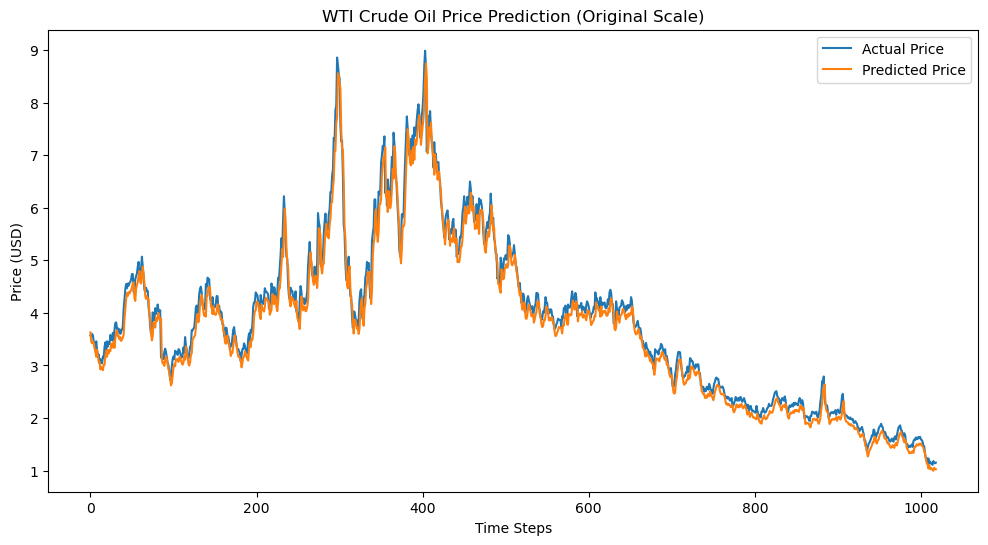

In [42]:
# --- inverse‐scale back to original prices ---
# note: Y_test is shape (n,), so we reshape it to (n,1) first
Y_test_rescaled    = scaler.inverse_transform(Y_test.reshape(-1,1))
predictions_rescaled = scaler.inverse_transform(predictions)

# --- plot in original price units ---
plt.figure(figsize=(12,6))
plt.plot(Y_test_rescaled,     label="Actual Price")
plt.plot(predictions_rescaled, label="Predicted Price")
plt.title("WTI Crude Oil Price Prediction (Original Scale)")
plt.xlabel("Time Steps")
plt.ylabel("Price (USD)")
plt.legend()
plt.show()
